# Attempt HMM on temporal and spactial data 

See if we can do the same as with the other HMMs, but with differnet data.
Can then see which points should be reclassified, and compare to what the other model says.
Can then take the intersection of these reclassifications to be sure.

In [1]:
# imports
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import nltk
import pickle
import matplotlib.pyplot as plt


In [2]:
# Load in data
# index_col stops index being read as column
df_turk = pd.read_csv('turk-Data-renamed.csv', index_col=0)
df_lab = pd.read_csv('lab-Data-renamed.csv', index_col=0)

In [6]:
df_turk[['time', 'x', 'y', 'turkId']]

,time,x,y,turkId
0,0.000,477.0,405.0,A35YFAFWP33C70
1,0.111,478.0,405.0,A35YFAFWP33C70
2,0.111,478.0,405.0,A35YFAFWP33C70
3,1.516,479.0,405.0,A35YFAFWP33C70
4,2.395,543.0,403.0,A35YFAFWP33C70
...,...,...,...,...
1293068,258.656,500.0,2198.0,A15781PHGW377Y
1293069,258.656,500.0,2198.0,A15781PHGW377Y
1293070,258.656,500.0,2198.0,A15781PHGW377Y
1293071,258.656,500.0,2198.0,A15781PHGW377Y


In [19]:
df_lab_series = df_lab[['time', 'x', 'y', 'turkId']]

# Attempt to truncate time from 15.21783 to 15
# Then delete duplicates
df_lab_series['time'] = df_lab_series['time'].apply(np.floor)
df_lab_series

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,time,x,y,turkId
0,0.0,397.0,647.0,ID1
1,0.0,423.0,642.0,ID1
2,0.0,423.0,642.0,ID1
3,1.0,426.0,642.0,ID1
4,1.0,440.0,640.0,ID1
...,...,...,...,...
58280,275.0,942.0,1248.0,ID18
58281,275.0,942.0,1248.0,ID18
58282,275.0,942.0,1248.0,ID18
58283,275.0,942.0,1248.0,ID18


In [31]:
# Lots of missing timestamps.
# Instead use just the order of them as before.
# Num of events is simlar to time anyway so should be fine?

df_lab_seq = df_lab[['x', 'y', 'turkId']]
lab_dups = len(df_lab_seq)-len(df_lab_seq.drop_duplicates())
print(f'Number of duplicate items in lab data: {lab_dups}')
print(f'Percentage duplicate: {lab_dups / len(df_lab_seq) * 100}\n')
df_lab_seq = df_lab_seq.drop_duplicates()

data_lab = df_lab_seq[['x', 'y']].to_numpy().reshape(-1, 2).astype(np.int)

df_turk_seq = df_turk[['x', 'y', 'turkId']]
turk_dups = len(df_turk_seq)-len(df_turk_seq.drop_duplicates())
print(f'Number of duplicate items in turk data: {turk_dups}')
print(f'Percentage duplicate: {turk_dups / len(df_turk_seq) * 100}')
df_turk_seq = df_turk_seq.drop_duplicates()

data_turk = df_turk_seq[['x', 'y']].astype('int32').to_numpy().reshape(-1, 2).astype(np.int)

# TODO: try with duplicates as could be important, someone leaving there mouse still for a while

Number of duplicate items in lab data: 11216
Percentage duplicate: 29.938073884262224

Number of duplicate items in turk data: 226995
Percentage duplicate: 23.320789143573954


In [30]:
# want to have everything in one long array.
# But then we need to create the lengths array.

lab_lengths = []
for ID in df_lab_seq['turkId'].unique():
    length_for_ID = len( df_lab_seq[df_lab_seq['turkId'] == ID] )
    lab_lengths.append(length_for_ID)

turk_lengths = []
for ID in df_turk_seq['turkId'].unique():
    length_for_ID = len( df_turk_seq[df_turk_seq['turkId'] == ID] )
    turk_lengths.append(length_for_ID)

In [52]:
# 6 states, 50 iter = -296955

lab_model = hmm.GaussianHMM(n_components=8, random_state=0, n_iter=50, verbose=True).fit(data_lab, lab_lengths)


1     -357598.7113             +nan
         2     -330312.7784      +27285.9328
         3     -317480.8826      +12831.8958
         4     -308151.4289       +9329.4537
         5     -302530.8766       +5620.5523
         6     -301671.5162        +859.3604
         7     -300570.5648       +1100.9514
         8     -296909.3033       +3661.2616
         9     -290528.4378       +6380.8655
        10     -288701.6212       +1826.8165
        11     -288638.4074         +63.2138
        12     -288623.6847         +14.7228
        13     -288618.6327          +5.0519
        14     -288616.6587          +1.9741
        15     -288614.8804          +1.7783
        16     -288609.5461          +5.3342
        17     -288601.6686          +7.8775
        18     -288599.0700          +2.5986
        19     -288597.9746          +1.0954
        20     -288597.0981          +0.8765
        21     -288596.2833          +0.8148
        22     -288595.4612          +0.8221
        23     -288

In [53]:
# 6 states, 50 iter = -8797740

turk_model = hmm.GaussianHMM(n_components=8, random_state=0, n_iter=50, verbose=True).fit(data_turk, turk_lengths)

1   -10340211.0549             +nan
         2    -9671096.8447     +669114.2102
         3    -9264697.7371     +406399.1076
         4    -9049892.1907     +214805.5464
         5    -8971598.2620      +78293.9288
         6    -8855231.1388     +116367.1231
         7    -8769283.1059      +85948.0329
         8    -8738199.6381      +31083.4678
         9    -8693687.3429      +44512.2952
        10    -8668250.2546      +25437.0883
        11    -8664413.2816       +3836.9730
        12    -8663239.5371       +1173.7445
        13    -8662345.0079        +894.5292
        14    -8661272.2026       +1072.8053
        15    -8660000.8298       +1271.3728
        16    -8658744.1107       +1256.7191
        17    -8657841.8410        +902.2696
        18    -8657358.8855        +482.9556
        19    -8657168.1912        +190.6943
        20    -8657096.5192         +71.6720
        21    -8657066.0720         +30.4472
        22    -8657055.3113         +10.7607
        23    -8657

In [54]:

# Have to have all this extra code because the data is stored in a big long list so need to kind of extract the user details again.

def model_score_list(model, data, lengths):
    # Given a model and some data and lengths return a list of likelihoods that each different data sample belongs to that HMM.

    probas = []

    start_i = 0
    #end_i = start_i + lab_lengths[0]
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        #print(i)
        #print( model.score( users_items ) )
        probas.append( model.score(users_items) )

        start_i = lengths[i] # lab_lengths[0]
        #end_i = start_i + lab_lengths[i+1]

    return probas

# Score is given as a liklihood https://web.stanford.edu/~jurafsky/slp3/A.pdf
# Somthing like summing the likelihoods of each hidden state producing the same output as the input at the same location?   
model_score_list(turk_model, data_lab, lab_lengths)    # Try lab data on turk model

[-22649.459435306002,
 -19350.186273285395,
 -19466.64579627351,
 -6376.487184150367,
 -6003.088936409435,
 -47763.46756315109,
 -13065.51970102258,
 -4913.15176474156,
 -42153.62755972911,
 -4574.977693679633,
 -36157.7389847479,
 -36925.6797608968,
 -20744.4367301452,
 -20827.027877555283]

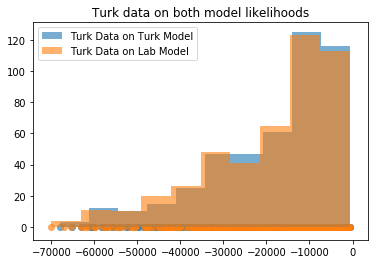

In [55]:
turk_data_turk_model = model_score_list(turk_model, data_turk, turk_lengths)  # Try turk data on turk model
turk_data_lab_model = model_score_list(lab_model, data_turk, turk_lengths)  # Try turk data on lab model

plt.hist(turk_data_turk_model, bins=10, label='Turk Data on Turk Model', alpha=0.6)
plt.hist(turk_data_lab_model, bins=10, label='Turk Data on Lab Model', alpha=0.6)

plt.title('Turk data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( turk_data_turk_model, np.zeros((len(turk_data_turk_model),1)), label='Turk Data on Turk Model', alpha=0.6 )
plt.scatter( turk_data_lab_model, np.zeros((len(turk_data_lab_model),1)), label='Turk Data on Lab Model', alpha=0.6 )

plt.show()

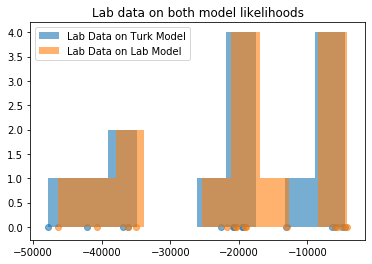

In [56]:
# This graph clearly shows that on average, the lab data is more likely to be classified as a turk model.

lab_data_turk_model = model_score_list(turk_model, data_lab, lab_lengths)  # Try lab data on turk model
lab_data_lab_model = model_score_list(lab_model, data_lab, lab_lengths)  # Try lab data on lab model

plt.hist(lab_data_turk_model, bins=10, label='Lab Data on Turk Model', alpha=0.6)
plt.hist(lab_data_lab_model, bins=10, label='Lab Data on Lab Model', alpha=0.6)

plt.title('Lab data on both model likelihoods')
plt.legend(loc='best')

# Also show the individual points on there too because why not.
plt.scatter( lab_data_turk_model, np.zeros((len(lab_data_turk_model),1)), label='Lab Data on Turk Model', alpha=0.6 )
plt.scatter( lab_data_lab_model, np.zeros((len(lab_data_lab_model),1)), label='Lab Data on Lab Model', alpha=0.6 )

plt.show()

In [57]:
# Plotting results

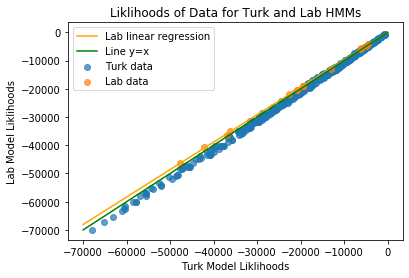

In [58]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, alpha=0.7, label='Turk data')
plt.scatter(lab_data_turk_model, lab_data_lab_model, alpha=0.7, label='Lab data')

plt.title('Liklihoods of Data for Turk and Lab HMMs')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')
#plt.show()

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-70000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-70000,0,100)
y = x
plt.plot(x, y, 'green', label='Line y=x')

plt.legend()

plt.show()

In [59]:
# Reassign samples


# Test readdign samples a different way.
# If a point is above and to the left of the orange line then we can say that the data matches the lab model compared to the turk model to the same extent as the actual lab data.

def reclassify_samples(turk_model, lab_model, data, lengths):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood
        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

def reclassify_samples_regression(turk_model, lab_model, data, lengths, reg):
    '''
    Returns array of new classes.
    reg is a linear regression object of the lab data.
    0 is turk, 1 is lab.
    '''
    # Given a model and some data and lengths return a list of predicted new classes.

    M = reg.coef_[0][0]
    C = reg.intercept_[0]

    new_classes = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]
        
        # Turks are 0, labs are 1

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)

        Y = lab_likelihood
        X = turk_likelihood

        # Y= MX + C is equation of straight line.
        # if Y > MX + C then the point is above the line    
        # https://math.stackexchange.com/questions/324589/detecting-whether-a-point-is-above-or-below-a-slope

        #print(f'User {i}: \t turk: {int(turk_likelihood)}, \t lab: {int(lab_likelihood)}, \t mX+c: {M*X+C}')

        if ( Y > M*X + C ):
            new_classes.append(1)
        else:
            new_classes.append(0)

        if ( turk_likelihood > lab_likelihood ):
            new_classes.append(0)
        else:
            new_classes.append(1)

        start_i = lengths[i] 

        start_i = lengths[i] 

    return new_classes

# Lab data is half classified as itself. GOOD
reclassified_lab_labels = reclassify_samples(turk_model, lab_model, data_lab, lab_lengths)
reclassified_lab_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_lab, lab_lengths, reg)

print('Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels.count(0), reclassified_lab_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_lab_labels_reg.count(0), reclassified_lab_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
0 14

REG Number of new turk labels, number of new lab labels:
6 22


In [60]:
reclassified_turk_labels = reclassify_samples(turk_model, lab_model, data_turk, turk_lengths)    # Try turk data
reclassified_turk_labels_reg = reclassify_samples_regression(turk_model, lab_model, data_turk, turk_lengths, reg)    # Try turk data

print('Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels.count(0), reclassified_turk_labels.count(1))
print()
print('REG Number of new turk labels, number of new lab labels:')
print(reclassified_turk_labels_reg.count(0), reclassified_turk_labels_reg.count(1))

Number of new turk labels, number of new lab labels:
424 37

REG Number of new turk labels, number of new lab labels:
885 37


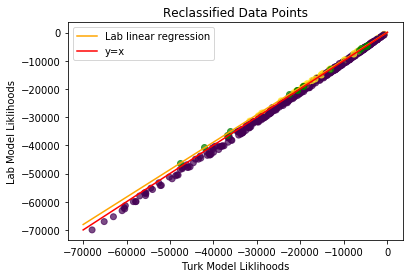

In [61]:
plt.scatter(turk_data_turk_model, turk_data_lab_model, c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_data_turk_model, lab_data_lab_model, c='g', alpha=0.7)

plt.title('Reclassified Data Points')
plt.xlabel('Turk Model Liklihoods')
plt.ylabel('Lab Model Liklihoods')

# Linear reg of just lab data
X = np.array(lab_data_turk_model).reshape(-1,1)
y = np.array(lab_data_lab_model).reshape(-1,1)
reg = LinearRegression().fit(X, y)
#pred=reg.predict(X)
#plt.plot(X, pred, 'r', alpha=0.6)

x = np.linspace(-70000,0,100)
y = reg.coef_[0][0]*x + reg.intercept_[0]
plt.plot(x, y, 'orange', label='Lab linear regression')

x = np.linspace(-70000,100,100)
y = 1*x+0
plt.plot(x, y, 'r', label='y=x')

plt.legend()

plt.show()

# These scatterplots show that there is not anywhere near as much variance with the turk model predictions as the lab model predictions.
# Probably due to the fact we didtnt have much data to train the lab model with.
# The positive quadrant shows that shows that while the turk likelihoods are always slightly higher, theyre directly correlated and not much difference.
# Can we accume any positive likelihood from the lab model using turk data means theyre paying attention?

Turk likelihoods  Lab likelihoods  Difference   ID
0     -22649.459435    -21767.683541 -881.775894  ID1
1     -19350.186273    -19009.995480 -340.190794  ID2
2     -19466.645796    -19068.973190 -397.672606  ID3
3      -6376.487184     -6038.928866 -337.558318  ID4
4      -6003.088936     -5573.871852 -429.217085  ID5


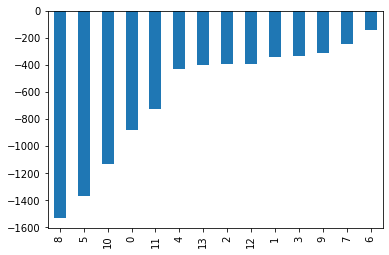

In [63]:
def compare_model_liklihoods(turk_model, lab_model, data, lengths, IDs):
    # Given a model and some data and lengths return a dataframe of each user, and the liklihoods for different models.
    # Difference is turklikelihood - lab_liklihood.
    # Therefore a high positive number means its firmly turk, a low negative number means its firmly lab.

    res = []

    start_i = 0
    end_i = 0

    for i in range(len(lengths)):
        end_i = start_i + lengths[i]

        users_items = data[start_i:end_i]

        turk_likelihood = turk_model.score(users_items)
        lab_likelihood = lab_model.score(users_items)
        difference = turk_likelihood - lab_likelihood
        ID = IDs[i]

        res.append( (turk_likelihood, lab_likelihood, difference, ID) )

        start_i = lengths[i] 

    df = pd.DataFrame.from_records(res, columns =['Turk likelihoods', 'Lab likelihoods', 'Difference', 'ID']) 

    return df

df_lab_diff = compare_model_liklihoods(turk_model, lab_model, data_lab, lab_lengths, df_lab_seq['turkId'].unique().tolist())    # Try lab data
print(df_lab_diff.head())
df_lab_diff['Difference'].sort_values().plot(kind='bar')

Turk likelihoods  Lab likelihoods   Difference              ID
0      -3314.200166     -3690.442977   376.242811  A35YFAFWP33C70
1      -6263.308024     -6556.008928   292.700904  A33XI8ZN4NZ0SQ
2     -10333.827295    -11344.501302  1010.674007  A1ZG7VYH0DUEXW
3      -6318.475649     -7145.907654   827.432004  A1RXG8RE0SJ4LC
4      -1423.138810     -1559.945872   136.807062   AUDH0P4ZHJKS2


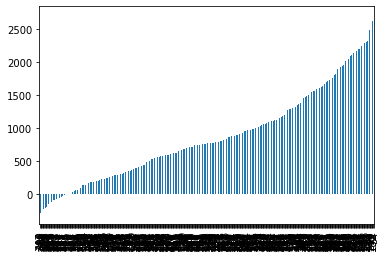

In [65]:
df_turk_diff = compare_model_liklihoods(turk_model, lab_model, data_turk, turk_lengths, df_turk_seq['turkId'].unique())    # Try turk data
print(df_turk_diff.head())
df_turk_diff['Difference'].sort_values().plot(kind='bar')

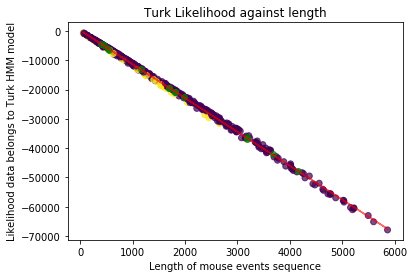

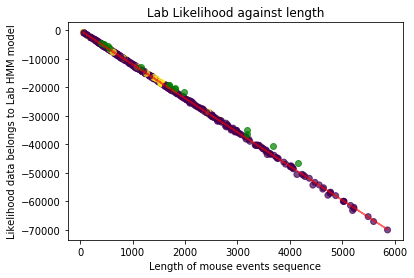

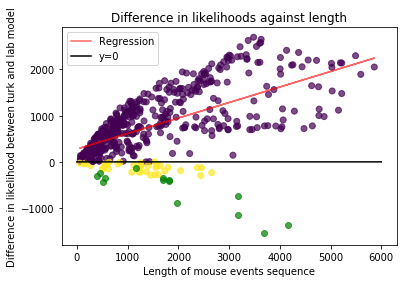

In [70]:

# Turk plot
plt.scatter(turk_lengths, df_turk_diff['Turk likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Turk likelihoods'], c='g', alpha=0.7)
plt.title('Turk Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Turk HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Turk likelihoods'].append(df_lab_diff['Turk likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()


# Lab plot
plt.scatter(turk_lengths, df_turk_diff['Lab likelihoods'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Lab likelihoods'], c='g', alpha=0.7)
plt.title('Lab Likelihood against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Likelihood data belongs to Lab HMM model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Lab likelihoods'].append(df_lab_diff['Lab likelihoods'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6)
plt.show()

# Difference plot
plt.scatter(turk_lengths, df_turk_diff['Difference'], c=reclassified_turk_labels, alpha=0.7)
plt.scatter(lab_lengths, df_lab_diff['Difference'], c='g', alpha=0.7)
plt.title('Difference in likelihoods against length')
plt.xlabel('Length of mouse events sequence')
plt.ylabel('Difference in likelihood between turk and lab model')

X = np.append(turk_lengths, lab_lengths).reshape(-1,1)
y = np.array(df_turk_diff['Difference'].append(df_lab_diff['Difference'])).reshape(-1,1)
reg = LinearRegression().fit(X, y)
pred=reg.predict(X)
plt.plot(X, pred, 'r', alpha=0.6, label='Regression')

x = np.linspace(0,6000,6000)
y = 0*x
plt.plot(x, y, 'k', label='y=0')
plt.legend()

plt.show()


In [71]:
# TODO: Save df_diffs to csv to explore with tableau. 

In [83]:
# Todo: print out the turk ids of people with negative differences.
# Do the same with other HMM and take intersection.


print(len(df_turk_diff[df_turk_diff['Difference'] < 0]))

reclassified_IDs = df_turk_diff[df_turk_diff['Difference'] < 0]['ID'].to_numpy()
reclassified_IDs

37


array(['A1O2S71TYP1AFC', 'AY2U544TCVPMQ', 'A38QM2WVQ7O9MF',
       'A1WJQFUJFDCST5', 'A2FQRMIL3DSKI4', 'A20X14OMRL0YPZ',
       'A1NQZSUQPL4K17', 'A3KYFEDDBCFQU1', 'A224B7BAQ0MZSN',
       'AFWKRID53R1XA', 'ABUNAEPK8GV63', 'A2BOUSPEKZYWDO',
       'A1Q5KU5RVDE67', 'A20IXK8ZV8N72H', 'A36K11N6R2A108',
       'AE837QZ9XU1UQ', 'A2KHV2D09JAWPC', 'A16NAK9LY0HRJS',
       'AUK4KGOJP9F0H', 'AACGKQ431VQSM', 'A3BY2WDCY8YLDE',
       'A2JA8QB8PGYGHJ', 'A2M6GFFEYJ5XP', 'AJVGW8ZY3SWE4',
       'AA8NOYG0AXRJO', 'A2OMY4DX7JQVU0', 'A2SZGJMBK4LSJ1',
       'A2T9WRHFRIVAFY', 'A1M28E133E3K5X', 'A35OLDOCJQBO38',
       'A2D50KS58QB1BN', 'A36DDHDQ56N60C', 'A30QJF394U1VRY',
       'A2MCRVU8I9VNHG', 'A4PFM9Z80RXUY', 'A13BTXTJQIXWTL',
       'A3T0IC6VPU9NJY'], dtype=object)

In [123]:
new = np.array(['A1O2S71TYP1AFC', 'AY2U544TCVPMQ', 'A38QM2WVQ7O9MF',
       'A1WJQFUJFDCST5', 'A2FQRMIL3DSKI4', 'A20X14OMRL0YPZ',
       'A1NQZSUQPL4K17', 'A3KYFEDDBCFQU1', 'A224B7BAQ0MZSN',
       'AFWKRID53R1XA', 'ABUNAEPK8GV63', 'A2BOUSPEKZYWDO',
       'A1Q5KU5RVDE67', 'A20IXK8ZV8N72H', 'A36K11N6R2A108',
       'AE837QZ9XU1UQ', 'A2KHV2D09JAWPC', 'A16NAK9LY0HRJS',
       'AUK4KGOJP9F0H', 'AACGKQ431VQSM', 'A3BY2WDCY8YLDE',
       'A2JA8QB8PGYGHJ', 'A2M6GFFEYJ5XP', 'AJVGW8ZY3SWE4',
       'AA8NOYG0AXRJO', 'A2OMY4DX7JQVU0', 'A2SZGJMBK4LSJ1',
       'A2T9WRHFRIVAFY', 'A1M28E133E3K5X', 'A35OLDOCJQBO38',
       'A2D50KS58QB1BN', 'A36DDHDQ56N60C', 'A30QJF394U1VRY',
       'A2MCRVU8I9VNHG', 'A4PFM9Z80RXUY', 'A13BTXTJQIXWTL',
       'A3T0IC6VPU9NJY'], dtype=object)

old = np.array(['A35YFAFWP33C70', 'A29D1BMFCC7XA1', 'AE3XJ3B4K4B15',
       'A1FA2AJUFESR5T', 'A37MEXKALGBQWN', 'A1O2S71TYP1AFC',
       'A2CIGX8GOEE58M', 'AVI7K876BV3QL', 'A2GSSXKTPAEL6D',
       'A24DZU2LIWZQCG', 'A2Y1AMYG74XRDO', 'A1067MT5UGN8Z8',
       'A3F82HVRIPI02N', 'A2GPMBGECD9TQY', 'AYW18ODUQFXF',
       'A2Z11BHUBDVKMB', 'A36470UBRH28GO', 'A23SGBJULXN5DO',
       'A19XS2I3H4JOJ8', 'A12J9J42MYQDRY', 'A30OOETQPWFPHK',
       'A3MELYYGRJ61SX', 'A28I7Y2NPDZTIN', 'A2TDLLB8JTZGBN',
       'A11O7VHY5Y5QUX', 'AJPQEZBVJXVE9', 'A1DGAZZZHY4FXG',
       'A3SFNMTK31EBV1', 'AC2TZJY3V7YVU', 'A1SS75GZE2AUOQ',
       'AQAXDL1INQC9Q', 'AAX1G2KA4ZD2N', 'ANPTFK4AAFGA1',
       'A2XM6C78S9L8UG', 'A1DZMDFI9U604W', 'A1HNTXZAIPFQNF',
       'A14U4WPDS8ITPQ', 'ATIWKEQ7WB1VH', 'A3PNHCZVCBIEJ1',
       'A2JQTK2ARSX01R', 'A3OF9HAEZVBQ3G', 'A2URTGY72HXIGG',
       'A3AM7D2UWBRS7Z', 'A21Y22J7Q0KSGN', 'A312SMN11YLE66',
       'A3QY3I5O0STFGA', 'AF3TLR0FI08K0', 'AWSCR2O3D6T87',
       'AFWKRID53R1XA', 'A2M2BNQ1XW3J4Y', 'AENW881YO2H8S',
       'ABUNAEPK8GV63', 'A2BA9Y6VGW6WS1', 'A31XNLA9REVGXL',
       'A8KX1HFH8NE2Q', 'A3ENEKASM9CUMS', 'A1NFBKUYYVUYWF',
       'AVPKE76DJLWK6', 'A2NJ7N8INZOB00', 'A19ZHL5Y6I7GCY',
       'A3BPS4K97FAU7O', 'A2CFE6AZS73RNS', 'A1DJD0J0BTE1X8',
       'A26L91YL0GDGD8', 'AZKC2HLJOVL04', 'A1YJKLVJW1FE33',
       'A28GQ44QN9DIH1', 'ACSZ7IOG3J5NR', 'A12176C3392N51',
       'ABFB6SB7ZPA3D', 'A39QYYAATL2XFT', 'A1M5R7IYPKXPEI',
       'A3H7LONGSJ9384', 'A1YNH3KJS5NHL1', 'A2OYWTFK9MCYJ1',
       'A2CKW83ERUX07J', 'A3LD1G3R5NOVYH', 'AAJEPFSQNC6X',
       'A13FT8BNX9UUP8', 'A2VTRIPL7H0IZH', 'A3R25SV8HUGML2',
       'A1ONILGBGJ8Y5K', 'AGVUHOBSCP6YC', 'AKI26MOILD9LU',
       'AVXEDARJC5HLU', 'A142HGTX0JO7YH', 'A357X6NIBOTHH0',
       'A2UIGDOLX5RV95', 'A35DUEG88GCX5J', 'A7XL1V3G7C2VV',
       'ABOEYY9Y0PFRI', 'A24I5N406D8R22', 'A2YL64PU2DBHTB',
       'A7R1OLLU1Z6RA', 'A1P8M5BKOTAA8I', 'A2S4YDJ9UGAXFQ',
       'ANVAFB99K5RKP', 'A2SWQM5X54P1O5', 'A2749DC85C9H0F',
       'A1ZHHL705SYZ1V', 'A2JPOXYZM5AJZZ', 'A28G4QO0DRY8OZ',
       'A35OLDOCJQBO38', 'AOAZMLP27GD81', 'A2JCK494NV7TFX',
       'A2KFOOEQWGN0GK', 'ACOKFBC75D5OR', 'A29ERTCD6HF72I',
       'A215VSM181SC0F', 'A4PFM9Z80RXUY', 'A1ETJBNTO9ZWZ8',
       'A3J2UG22S8BIW4'], dtype=object)

print(len(old), len(new))

np.intersect1d(old,new) # These 5 turks are classified as labs with both hmm methods

array(['A1O2S71TYP1AFC', 'A35OLDOCJQBO38', 'A4PFM9Z80RXUY',
       'ABUNAEPK8GV63', 'AFWKRID53R1XA'], dtype=object)

In [107]:
new_head = df_turk_diff.sort_values(['Difference'])['ID'].head(100).to_numpy()

In [108]:
old_head = np.array(['A39QYYAATL2XFT', 'A1NFBKUYYVUYWF', 'A7XL1V3G7C2VV',
       'A12176C3392N51', 'ACOKFBC75D5OR', 'A2GPMBGECD9TQY',
       'A1HNTXZAIPFQNF', 'A3QY3I5O0STFGA', 'AKI26MOILD9LU',
       'A2CKW83ERUX07J', 'ABFB6SB7ZPA3D', 'A29D1BMFCC7XA1',
       'A2VTRIPL7H0IZH', 'A3AM7D2UWBRS7Z', 'A3H7LONGSJ9384',
       'A12J9J42MYQDRY', 'AF3TLR0FI08K0', 'A8KX1HFH8NE2Q',
       'A2OYWTFK9MCYJ1', 'A2S4YDJ9UGAXFQ', 'A1067MT5UGN8Z8',
       'A14U4WPDS8ITPQ', 'A35YFAFWP33C70', 'A2YL64PU2DBHTB',
       'A2BA9Y6VGW6WS1', 'AOAZMLP27GD81', 'ANVAFB99K5RKP',
       'A2Z11BHUBDVKMB', 'A28I7Y2NPDZTIN', 'A1DZMDFI9U604W',
       'ACSZ7IOG3J5NR', 'A2JCK494NV7TFX', 'ABUNAEPK8GV63',
       'A1SS75GZE2AUOQ', 'A1ETJBNTO9ZWZ8', 'A31XNLA9REVGXL',
       'A2749DC85C9H0F', 'A28G4QO0DRY8OZ', 'A1YJKLVJW1FE33',
       'A4PFM9Z80RXUY', 'AVI7K876BV3QL', 'AGVUHOBSCP6YC',
       'A2CIGX8GOEE58M', 'A2GSSXKTPAEL6D', 'A19XS2I3H4JOJ8',
       'A2NJ7N8INZOB00', 'A2KFOOEQWGN0GK', 'A3F82HVRIPI02N',
       'A1ONILGBGJ8Y5K', 'A1DGAZZZHY4FXG', 'AAJEPFSQNC6X',
       'AAX1G2KA4ZD2N', 'ABOEYY9Y0PFRI', 'A29ERTCD6HF72I',
       'A2M2BNQ1XW3J4Y', 'A1ZHHL705SYZ1V', 'A3J2UG22S8BIW4',
       'A2CFE6AZS73RNS', 'AQAXDL1INQC9Q', 'A215VSM181SC0F',
       'A11O7VHY5Y5QUX', 'A36470UBRH28GO', 'AFWKRID53R1XA',
       'A30OOETQPWFPHK', 'A357X6NIBOTHH0', 'AYW18ODUQFXF',
       'A2UIGDOLX5RV95', 'A35OLDOCJQBO38', 'A1M5R7IYPKXPEI',
       'A2SWQM5X54P1O5', 'AVPKE76DJLWK6', 'AZKC2HLJOVL04',
       'A24DZU2LIWZQCG', 'A28GQ44QN9DIH1', 'A24I5N406D8R22',
       'A37MEXKALGBQWN', 'A2JQTK2ARSX01R', 'A1YNH3KJS5NHL1',
       'A21Y22J7Q0KSGN', 'AENW881YO2H8S', 'A1FA2AJUFESR5T',
       'AC2TZJY3V7YVU', 'A1DJD0J0BTE1X8', 'A19ZHL5Y6I7GCY',
       'A1O2S71TYP1AFC', 'A26L91YL0GDGD8', 'AVXEDARJC5HLU',
       'A3MELYYGRJ61SX', 'A3ENEKASM9CUMS', 'AWSCR2O3D6T87',
       'AE3XJ3B4K4B15', 'A35DUEG88GCX5J', 'A2Y1AMYG74XRDO',
       'A1P8M5BKOTAA8I', 'A2TDLLB8JTZGBN', 'A3PNHCZVCBIEJ1',
       'A3LD1G3R5NOVYH', 'A142HGTX0JO7YH', 'A7R1OLLU1Z6RA',
       'ANPTFK4AAFGA1'], dtype=object)

print(len(old_head), len(new_head))

print(len(np.intersect1d(old_head,new_head)))
np.intersect1d(old_head,new_head)


In [128]:
neg = np.intersect1d(old,new)
head = np.intersect1d(old_head,new_head)

print(len(head), len(neg))
print(len(np.union1d(head, neg)))
print(len(np.intersect1d(head, neg)))
np.intersect1d(head, neg)

21 5
21
5


array(['A1O2S71TYP1AFC', 'A35OLDOCJQBO38', 'A4PFM9Z80RXUY',
       'ABUNAEPK8GV63', 'AFWKRID53R1XA'], dtype=object)

In [119]:
len(head), len(neg)

(21, 5)

In [122]:
C

21